<a href="https://colab.research.google.com/github/sahilfatima/Penguins-EDA/blob/main/Penguins_EDA_and_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'penguins:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1154655%2F1935698%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240202%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240202T115522Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3b5a8da5c0b3cc9a650deaaa40f163b774db1ad7e1032e57a5deef7eb9ff34d429e2b33fb4fef5ceed7d355556b68f3d146713b6751d3536a4d5a55b97533e2f6f3a828800e9e59ea25a0afd87c68840c996ca4b79c42c8c3aa050896b114bfa5607740e8a228d5d9b33e5b84609254c8d359e3d31dbd6fd7c0e0c511bdf5a93e941a90080a467a97051d54a26348409c7b45bc7b94101d585e2a6e75a259d9cabf12ff74b6bd524afd59c28ac93ecb7c5c78bab4641d30dd101db6e68528d5786490fbc99952a089457377035148ab96fae50b801ffe126388818541beff9039b163f702575b871a12be6981f19659d1eba79a15a3de5983c538f1954989c4c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Statistical analysis
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Data modeling
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/penguins/penguins.csv


In [ ]:
data = pd.read_csv('/kaggle/input/penguins/penguins.csv', sep =',')

In [ ]:
data.head()

,Unnamed: 0,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         344 non-null    int64  
 1   species            344 non-null    object 
 2   island             344 non-null    object 
 3   bill_length_mm     342 non-null    float64
 4   bill_depth_mm      342 non-null    float64
 5   flipper_length_mm  342 non-null    float64
 6   body_mass_g        342 non-null    float64
 7   sex                333 non-null    object 
 8   year               344 non-null    int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 24.3+ KB


In [ ]:
#Descriptive Analysis on Dataset
data.describe()

,Unnamed: 0,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,344.000000,342.000000,342.000000,342.000000,342.000000,344.000000
mean,172.500000,43.921930,17.151170,200.915205,4201.754386,2008.029070
std,99.448479,5.459584,1.974793,14.061714,801.954536,0.818356
min,1.000000,32.100000,13.100000,172.000000,2700.000000,2007.000000
25%,86.750000,39.225000,15.600000,190.000000,3550.000000,2007.000000
50%,172.500000,44.450000,17.300000,197.000000,4050.000000,2008.000000
75%,258.250000,48.500000,18.700000,213.000000,4750.000000,2009.000000
max,344.000000,59.600000,21.500000,231.000000,6300.000000,2009.000000


In [ ]:
#Cleaning and dealing with outliers
data.isna().sum()

Unnamed: 0            0
species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64

In [ ]:
mask = pd.isnull(data).any(axis=1)
data[mask]

,Unnamed: 0,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
8,9,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN,2007
9,10,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN,2007
10,11,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN,2007
11,12,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN,2007
47,48,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN,2007
178,179,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN,2007
218,219,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN,2008
256,257,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN,2009
268,269,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN,2009


In [ ]:
data = data.dropna()
data.shape

(333, 9)

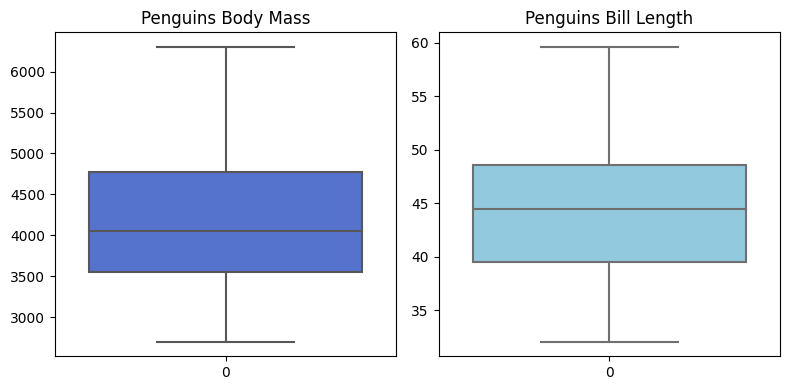

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))

sns.boxplot(data['body_mass_g'],showfliers=True, ax=axes[0], color='royalblue')
axes[0].set_title('Penguins Body Mass')

sns.boxplot(data['bill_length_mm'],showfliers=True, ax=axes[1], color='skyblue')
axes[1].set_title('Penguins Bill Length')

plt.tight_layout()

In [ ]:
data.duplicated().sum()

0

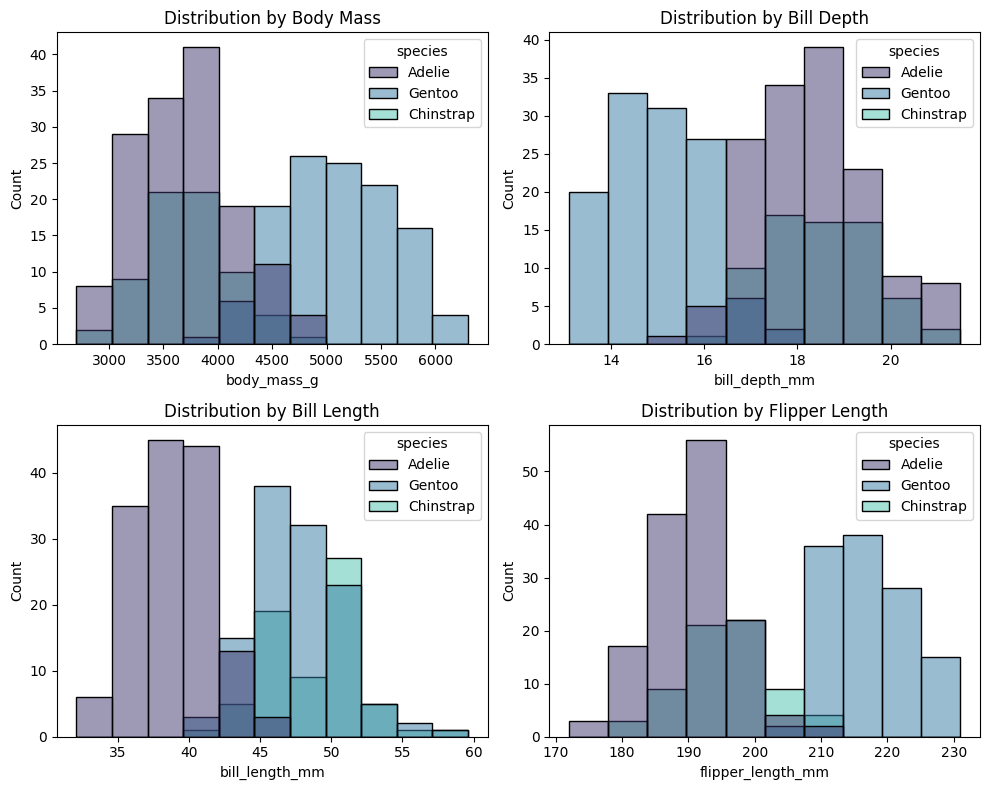

In [ ]:
#Data visualization > Continuous Variables
fig, axes = plt.subplots(2, 2, figsize=(10,8))

sns.histplot(data=data, x='body_mass_g', ax=axes[0,0], hue="species", palette='mako')
axes[0,0].set_title('Distribution by Body Mass')

sns.histplot(data=data, x='bill_length_mm', ax=axes[1,0], hue="species", palette='mako')
axes[1,0].set_title('Distribution by Bill Length')

sns.histplot(data=data, x='bill_depth_mm', ax=axes[0,1], hue="species", palette='mako')
axes[0,1].set_title('Distribution by Bill Depth')

sns.histplot(data=data, x='flipper_length_mm', ax=axes[1,1], hue="species", palette='mako')
axes[1,1].set_title('Distribution by Flipper Length')

plt.tight_layout()

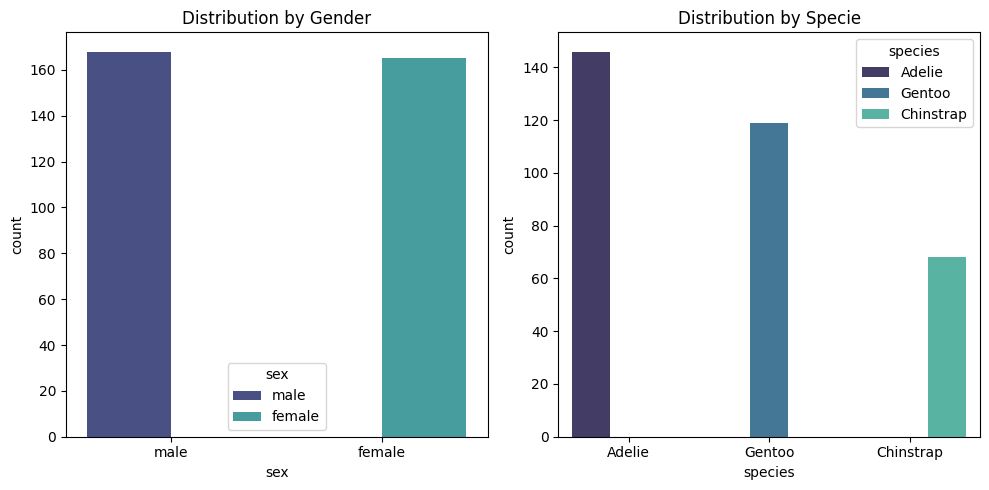

In [ ]:
#Data Visualizarion > Categorical Variables
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.countplot(data=data, x='sex', ax=axes[0], hue='sex', palette='mako')
axes[0].set_title('Distribution by Gender')

sns.countplot(data=data, x='species', ax=axes[1], hue='species' ,palette='mako')
axes[1].set_title('Distribution by Specie')

plt.tight_layout()

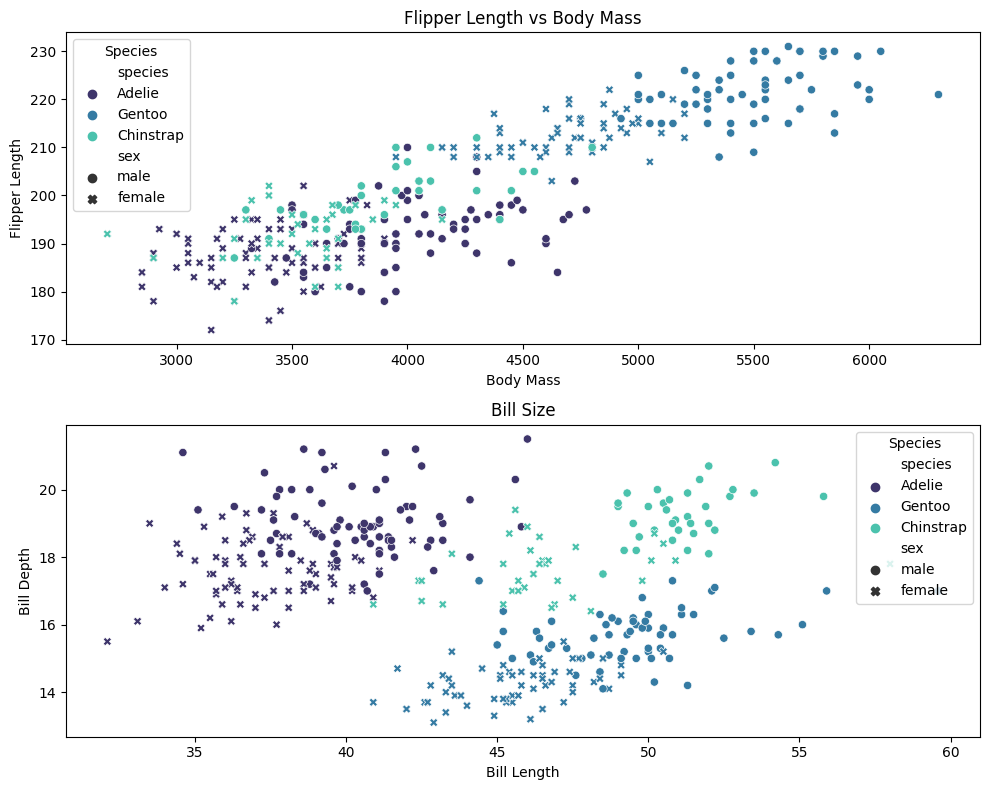

In [ ]:
#Data Visualization >For relationship between two variables
fig, axes = plt.subplots(2, 1, figsize=(10,8))
sns.scatterplot(data=data, x='body_mass_g', y='flipper_length_mm',hue='species', style='sex', ax=axes[0], palette='mako')
axes[0].set_title('Flipper Length vs Body Mass')
axes[0].set(xlabel='Body Mass', ylabel='Flipper Length')
axes[0].legend(title='Species')

sns.scatterplot(data=data, x='bill_length_mm', y='bill_depth_mm',hue='species', style='sex', ax=axes[1], palette='mako')
axes[1].set_title('Bill Size')
axes[1].set(xlabel='Bill Length', ylabel='Bill Depth')
axes[1].legend(title='Species')

plt.tight_layout()

In [ ]:
#Locating population
data['island'].unique()

array(['Torgersen', 'Biscoe', 'Dream'], dtype=object)

In [ ]:
#More information about Penguins
#Gather information
grouped = data[['island']].groupby(by='island')['island'].count()

grouped1 = data.groupby(['island','species']).count()



dictio = {'island':['Torgersen','Biscoe''Dream'], 'lat':[-64.7,-66,-64.7], 'lon':[-64,-65,-64.2],
          'Count':[47,123,163], 'Specie1':['Adelie','Adelie','Adelie'],'Specie2':['','Gentoo','Chinstrap']}

geo = pd.DataFrame({'island':['Torgersen','Biscoe','Dream'],
                   'lat':[-64.7,-66,-64.7],
                   'lon':[-64,-65,-64.2],
                   'count':[47,123,163],
                   'specie1':['Adelie','Adelie','Adelie'],
                   'specie2':[' ','Gentoo','Chinstrap']})
geo.head()

,island,lat,lon,count,specie1,specie2
0,Torgersen,-64.7,-64.0,47,Adelie,
1,Biscoe,-66.0,-65.0,123,Adelie,Gentoo
2,Dream,-64.7,-64.2,163,Adelie,Chinstrap


In [ ]:
#Population of penguins per island
fig = px.scatter_geo(geo, lat='lat',lon='lon', color="island", size='count',
                     projection="natural earth", center = {'lat':-64.7,'lon':-64.0},
                     title= 'Population of penguins per island')
fig.update_layout(legend_title='Island')
fig.show()

In [ ]:
#Data Modeling > Coorelation Check
correlation = data[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']].corr()
correlation

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
bill_length_mm,1.000000,-0.228626,0.653096,0.589451
bill_depth_mm,-0.228626,1.000000,-0.577792,-0.472016
flipper_length_mm,0.653096,-0.577792,1.000000,0.872979
body_mass_g,0.589451,-0.472016,0.872979,1.000000


<Axes: >

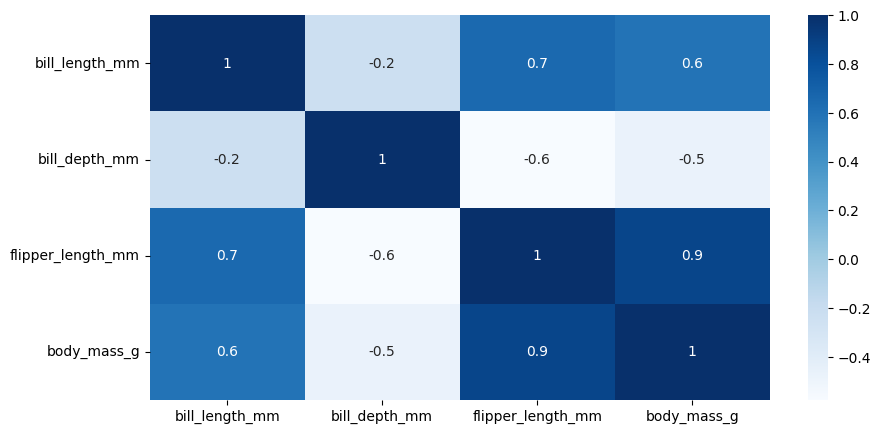

In [ ]:
plt.figure(figsize=(10, 5))
sns.heatmap(correlation, fmt=".1g", annot=True, cmap="Blues")

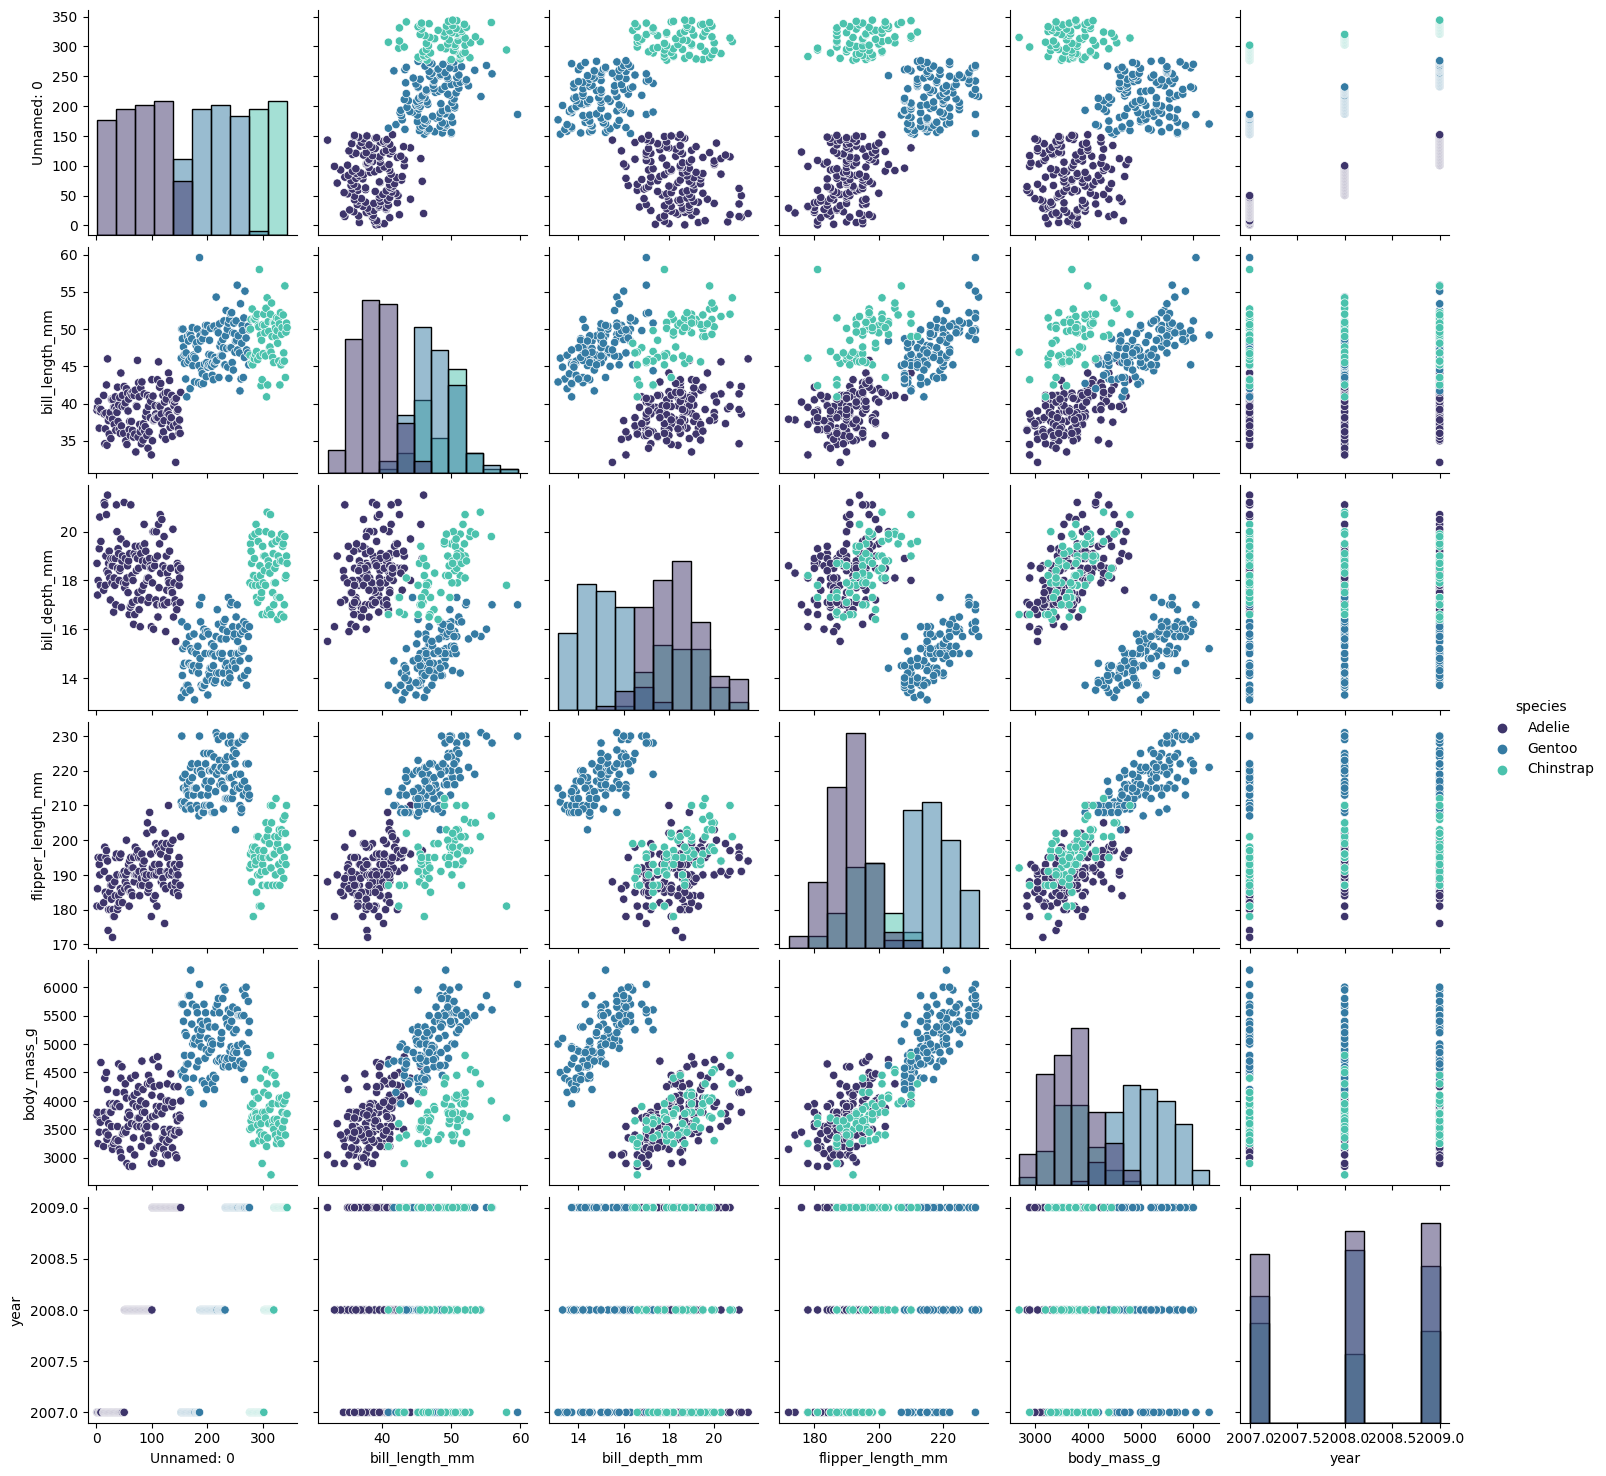

In [ ]:
sns.pairplot(data, hue='species', kind = 'scatter' , diag_kind='hist', palette='mako')

In [ ]:
#Building a model
penguins = data[["sex", "species","body_mass_g", "bill_length_mm"]]
penguins.reset_index(inplace=True, drop=True)
penguins.head()

,sex,species,body_mass_g,bill_length_mm
0,male,Adelie,3750.0,39.1
1,female,Adelie,3800.0,39.5
2,female,Adelie,3250.0,40.3
3,female,Adelie,3450.0,36.7
4,male,Adelie,3650.0,39.3


In [ ]:
#No outlier
print(penguins['species'].unique())
print(penguins['sex'].unique())
['Adelie' 'Gentoo' 'Chinstrap']
['male' 'female']

['Adelie' 'Gentoo' 'Chinstrap']
['male' 'female']


['malefemale']

In [ ]:
#Multiple Regression
X = penguins[['bill_length_mm', 'sex', 'species']]
y = penguins['body_mass_g']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
ols_formula = 'body_mass_g ~ bill_length_mm + C(sex) + C(species)'
ols_data = pd.concat([X_train,y_train], axis = 1)
OLS = ols(formula = ols_formula, data = ols_data)
model = OLS.fit()

Text(0.5, 1.0, 'OLS Data')

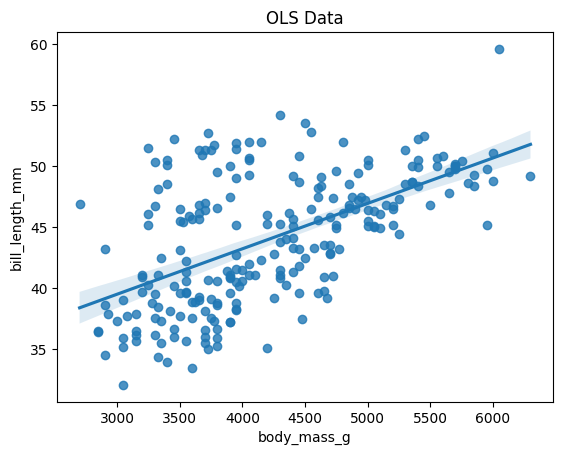

In [ ]:
#Model Summary
plt = sns.regplot(data=ols_data, x='body_mass_g', y='bill_length_mm')
plt.set_title('OLS Data')

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            body_mass_g   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     299.9
Date:                Mon, 08 Jan 2024   Prob (F-statistic):           1.48e-89
Time:                        11:44:04   Log-Likelihood:                -1677.0
No. Observations:                 233   AIC:                             3364.
Df Residuals:                     228   BIC:                             3381.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2004.7758    373.376      5.369      0.000    1269.066    2740.485
C(sex)[T.male]            561.9532     55.991     10.036      0.000     451.627     672.280
C(species)[T.Chinstrap]  -363.2300    114.769     -3.165      0.002    -589.374    -137.086
C(species)[T.Gentoo]     1055.0760     98.944     10.663      0.000     860.115    1250.037
bill_length_mm             36.7469     10.029      3.664      0.000      16.986      56.508
==============================================================================
Omnibus:                        1.105   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.575   Jarque-Bera (JB):                1.075
Skew:                           0.007   Prob(JB):                        0.584
Kurtosis:                       2.668   Cond. No.                         821.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#The final result of the model process culminated in a clear report, which can be broken down into the following bullet points:

#The first metric to investigate is the Adjusted R Squared, which tells us that 84% of the change in the dependent variable, in this case, the body mass of the penguins can be explained by the model. This means that our results are valuable.

#Moving on to the beta coefficients, in this case, bill length, gender (categorical), and species (categorical); the model took as base a female Adeline penguin. The results tell us that a male specimen will weigh 545 grams more than a female one, the Chinstrap type will be 341 grams lighter than an Adeline species and the Gentoo will be 1045 grams heavier.

#In the case of the bill length independent of the species or gender, the change of one millimeter in the bill will increase the mass by 34.5 grams.

#All the results have a small p-value, less than 0.05, which means that there is statistical significance in the metrics.

In [ ]:
#Model Assumptions->

#To ensure our model selection, we examined key assumptions. Two considerations, linearity and independence of observations. The validation of linearity was tested through visualization techniques, while the independence of observations was affirmed by each row representing a unique penguin in the dataset

In [ ]:
#Normality
residuals = model.resid

Text(0.5, 1.0, 'Histogram of Residuals')

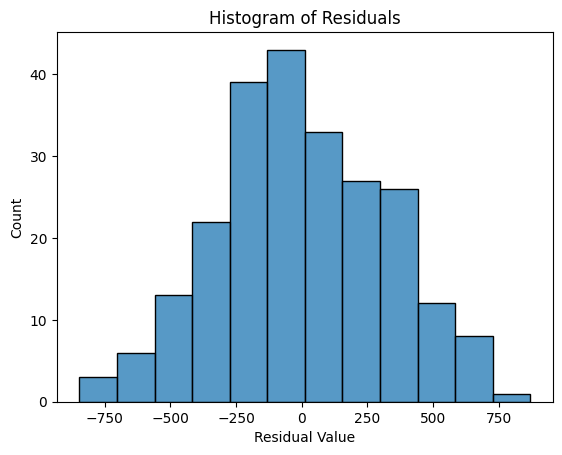

In [ ]:
fig = sns.histplot(residuals)
fig.set_xlabel("Residual Value")
fig.set_title("Histogram of Residuals")

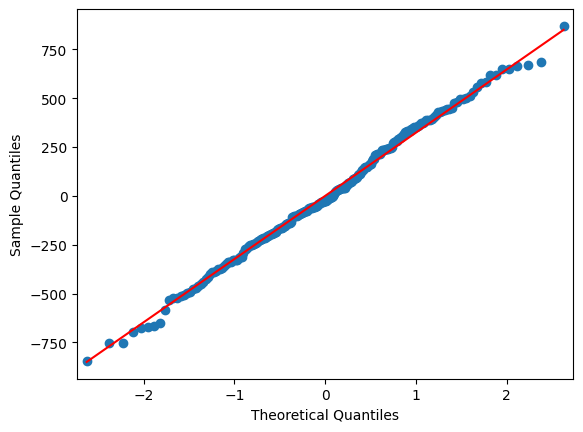

In [ ]:
fig = sm.qqplot(model.resid, line = 's')

Text(0, 0.5, 'Residuals')

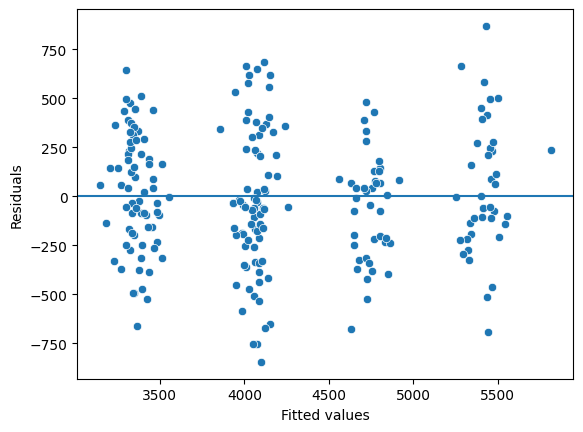

In [ ]:
#Homoscedasticity
fitted_values = model.predict(X)

fig = sns.scatterplot(x=fitted_values, y = residuals)

fig.axhline(0)

fig.set_xlabel("Fitted values")
fig.set_ylabel("Residuals")
